## Import TensorFlow and other libraries

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds 

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [62]:
# Load MNIST dataset using tfds
ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
(ds_train, ds_test) = ds

# Convert to numpy arrays
def preprocess_mnist(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Apply preprocessing and convert to numpy
x_train = np.array([preprocess_mnist(x, y).numpy() for x, y in ds_train])
x_test = np.array([preprocess_mnist(x, y).numpy() for x, y in ds_test])

print(x_train.shape)  # Should be (60000, 28, 28, 1)
print(x_test.shape)   # Should be (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


2025-10-22 02:18:17.950234: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [63]:
sample = ds_train.take(1)
for image, label in sample:
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (28, 28, 1)
Label: 4


In [64]:
# print first labels of training set
train_labels = np.array([y.numpy() for x, y in ds_train])
test_labels = np.array([y.numpy() for x, y in ds_test])

print(train_labels[:10])  # Display first 10 labels

[4 1 0 7 8 1 2 7 1 6]


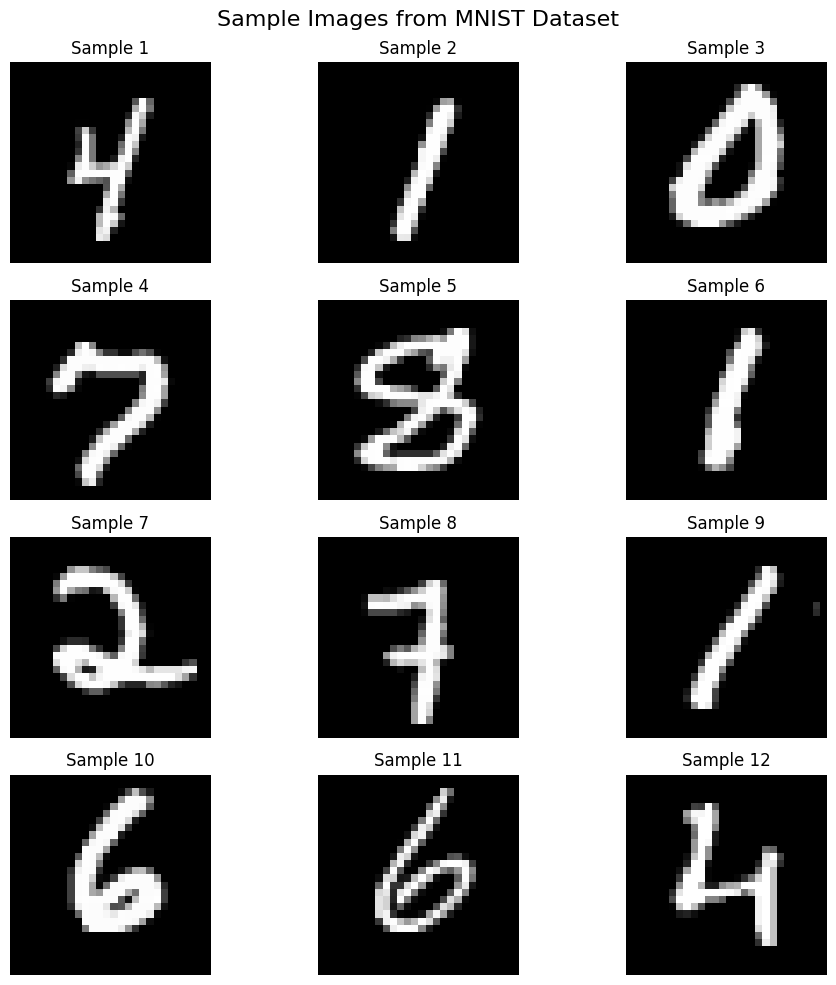

In [65]:
# Display a 3x3 grid of sample MNIST digits
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')  # Use .squeeze() and cmap='gray'
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle("Sample Images from MNIST Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [66]:
# Print comprehensive dataset statistics
print("=== MNIST Dataset Statistics ===")
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Image dimensions: {x_train.shape[1]} x {x_train.shape[2]} pixels")
print(f"Number of channels: {x_train.shape[3]} (Grayscale)")
print(f"Total training samples: {x_train.shape[0]:,}")
print(f"Total test samples: {x_test.shape[0]:,}")
print(f"Data type: {x_train.dtype}")
print(f"Pixel value range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Memory usage (training): {x_train.nbytes / (1024**2):.1f} MB")
print(f"Memory usage (test): {x_test.nbytes / (1024**2):.1f} MB")

# MNIST class names (digits 0-9)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

=== MNIST Dataset Statistics ===
Training set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Image dimensions: 28 x 28 pixels
Number of channels: 1 (Grayscale)
Total training samples: 60,000
Total test samples: 10,000
Data type: float32
Pixel value range: [0.000, 1.000]
Memory usage (training): 179.4 MB
Memory usage (test): 29.9 MB
Number of classes: 10
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Basic autoencoder

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [223]:
from tensorflow.keras import regularizers

# Define an Autoencoder class inheriting from tf.keras.Model
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()  # Initialize the base class
    self.latent_dim = latent_dim         # Store the size of the latent space
    self.shape = shape                   # Store the original input shape

    # Encoder: flattens input and encodes to latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # Flatten input to 1D
      layers.Dense(
        latent_dim, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)),  # Dense layer for encoding
    ])

    # Decoder: reconstructs original shape from latent vector
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),  # Dense layer to expand back to original size
      layers.Reshape(shape)               # Reshape output to original input shape
    ])

    # Classifier: reshape latent vector to 4D before Conv2D
    self.classifier = tf.keras.Sequential([
        layers.Reshape((8, 8, 1)),                  # Reshape 64 to (8, 8, 1)
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ])
    
    # Classifier: classify digits from latent space
    self.classifier = tf.keras.Sequential([
        layers.Conv2D(32, (8, 8), activation='relu'),    
        layers.Flatten(),                               # Flatten before Dense
        layers.Dense(10, activation='softmax')          # Output layer for 10 classes
    ])

  # Forward pass: encode then decode
  def call(self, x):
    encoded = self.encoder(x)             # Encode input
    reshaped = tf.reshape(encoded, (-1, 8, 8, 1)) # reshape input for classifier
    decoded = self.decoder(encoded)       # Decode latent vector
    class_probs = self.classifier(reshaped)  # Classify from latent space
    return decoded, class_probs           # Return reconstruction and class probabilities

# Set the shape and latent dimension for the autoencoder
shape = x_test.shape[1:]                  # Get shape of input images (e.g., (28, 28))
latent_dim = 64                           # Set size of latent space

# Instantiate the Autoencoder model
autoencoder = Autoencoder(latent_dim, shape)


Mean Squared Error (MSE) is commonly used as the loss function for autoencoders working with images because it measures the average squared difference between the original and reconstructed pixel values. This is appropriate for images because:

- **Pixel-wise similarity:** MSE penalizes large differences between corresponding pixels, encouraging the autoencoder to produce reconstructions that are visually similar to the input.
- **Continuous values:** Image data is often represented as continuous values (e.g., pixel intensities between 0 and 1), making MSE a natural choice.
- **Smooth gradients:** MSE provides smooth and stable gradients, which helps neural networks learn effectively during training.

In summary, MSE is simple, effective, and aligns well with the goal of minimizing reconstruction error in image autoencoders.

In [224]:
autoencoder.compile(optimizer='adam', loss=[losses.MeanSquaredError(), 'sparse_categorical_crossentropy'], metrics=['mse','accuracy'])

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [226]:
# Store the training history first
history = autoencoder.fit(x_train, [x_train, train_labels],
                epochs=20,
                shuffle=True,
                validation_data=(x_test, [x_test, test_labels]))

Epoch 1/20
 372/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9773 - loss: 0.1470 - mean_squared_error_loss: 0.0173 - mse: 0.0173 - sparse_categorical_crossentropy_loss: 0.0738

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9752 - loss: 0.1523 - mean_squared_error_loss: 0.0171 - mse: 0.0171 - sparse_categorical_crossentropy_loss: 0.0796 - val_accuracy: 0.9693 - val_loss: 0.1742 - val_mean_squared_error_loss: 0.0163 - val_mse: 0.0163 - val_sparse_categorical_crossentropy_loss: 0.1016
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9757 - loss: 0.1497 - mean_squared_error_loss: 0.0169 - mse: 0.0169 - sparse_categorical_crossentropy_loss: 0.0772 - val_accuracy: 0.9700 - val_loss: 0.1711 - val_mean_squared_error_loss: 0.0175 - val_mse: 0.0175 - val_sparse_categorical_crossentropy_loss: 0.0972
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9764 - loss: 0.1491 - mean_squared_error_loss: 0.0170 - mse: 0.0170 - sparse_categorical_crossentropy_loss: 0.0765 - val_accuracy: 0.9678 - val_loss: 0.1715 - val_mean_squared_error_loss: 0.0174 - val_mse: 0.0174 - val_sparse_categorical_crossentropy_loss: 0.0984
Epoch 4/20
1875

In [227]:
# 1. Training History Visualization
def plot_training_history(history):
    """Plot comprehensive training metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot accuracy curves
    plt.subplot(2, 3, 4)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot Loss difference (overfitting indicator)
    plt.subplot(2, 3, 2)
    loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    plt.plot(loss_diff, color='red', linewidth=2)
    plt.title('Validation - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # Plot Training statistics
    plt.subplot(2, 3, 3)
    min_train_loss = min(history.history['loss'])
    min_val_loss = min(history.history['val_loss'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    stats_text = f"""Training Statistics:
    
Min Training Loss: {min_train_loss:.6f}
Min Validation Loss: {min_val_loss:.6f}
Final Training Loss: {final_train_loss:.6f}
Final Validation Loss: {final_val_loss:.6f}

Epochs Trained: {len(history.history['loss'])}
Overfitting Gap: {final_val_loss - final_train_loss:.6f}
    """
    
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=10)
    plt.axis('off')
    plt.title('Training Summary')
    
    plt.tight_layout()
    plt.show()

# 2. Real-time reconstruction quality during training
def visualize_reconstruction_progress(model, x_sample, epoch_interval=2):
    """Visualize how reconstructions improve during training"""
    sample_images = x_sample[:5]  # Take 5 sample images
    
    def plot_reconstructions(epoch):
        reconstructions = model(sample_images)
        
        plt.figure(figsize=(15, 6))
        for i in range(5):
            # Original
            plt.subplot(2, 5, i + 1)
            plt.imshow(sample_images[i].squeeze(), cmap='gray')
            plt.title(f'Original {i+1}')
            plt.axis('off')
            
            # Reconstruction
            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstructions[i].squeeze(), cmap='gray')
            plt.title(f'Epoch {epoch}')
            plt.axis('off')
        
        plt.suptitle(f'Reconstruction Quality at Epoch {epoch}')
        plt.tight_layout()
        plt.show()
    
    return plot_reconstructions

# 3. Loss landscape visualization
def plot_loss_landscape_analysis(history):
    """Analyze the loss landscape and training dynamics"""
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Loss ratio analysis
    plt.subplot(2, 3, 1)
    val_train_ratio = np.array(history.history['val_loss']) / np.array(history.history['loss'])
    plt.plot(val_train_ratio, linewidth=2, color='purple')
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Ratio')
    plt.title('Validation/Training Loss Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Loss improvement rate
    plt.subplot(2, 3, 2)
    train_improvement = -np.diff(history.history['loss']) # get pairwise differences
    val_improvement = -np.diff(history.history['val_loss']) # get pairwise differences
    
    plt.plot(train_improvement, label='Training Improvement', alpha=0.7)
    plt.plot(val_improvement, label='Validation Improvement', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Loss Improvement Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Decrease')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Training stability
    plt.subplot(2, 3, 3)
    window = 3
    train_std = np.array([np.std(history.history['loss'][max(0, i-window):i+1]) 
                         for i in range(len(history.history['loss']))])
    plt.plot(train_std, linewidth=2, color='green')
    plt.title('Training Stability (Loss Std)')
    plt.xlabel('Epoch')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Early stopping analysis
    plt.subplot(2, 3, 4)
    patience = 5
    best_val_loss = np.inf
    patience_counter = 0
    early_stop_points = []
    
    for i, val_loss in enumerate(history.history['val_loss']):
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            early_stop_points.append(i)
    
    plt.plot(history.history['val_loss'], linewidth=2)
    for point in early_stop_points:
        plt.axvline(x=point, color='red', linestyle='--', alpha=0.7)
    plt.title(f'Early Stopping Analysis (Patience={patience})')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Gradient estimation
    plt.subplot(2, 3, 5)
    train_gradient = np.gradient(history.history['loss'])
    val_gradient = np.gradient(history.history['val_loss'])
    
    plt.plot(train_gradient, label='Training Gradient', alpha=0.7)
    plt.plot(val_gradient, label='Validation Gradient', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Loss Gradients')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Training phases
    plt.subplot(2, 3, 6)
    epochs = len(history.history['loss'])
    
    # Identify training phases based on loss behavior
    phase_changes = []
    for i in range(1, epochs-1):
        prev_slope = history.history['loss'][i] - history.history['loss'][i-1]
        next_slope = history.history['loss'][i+1] - history.history['loss'][i]
        if prev_slope * next_slope < 0:  # Sign change
            phase_changes.append(i)
    
    plt.plot(history.history['loss'], linewidth=2, label='Training Loss')
    for change in phase_changes:
        plt.axvline(x=change, color='red', linestyle=':', alpha=0.7)
    
    plt.title('Training Phase Changes')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 4. Model capacity analysis
def analyze_model_capacity(model, x_train, x_test):
    """Analyze if the model has appropriate capacity"""
    plt.figure(figsize=(12, 8))
    
    # Get predictions for analysis as a list [[reconstruction, class_probs], ...]
    train_reconstructions = model(x_train[:1000])  # Subset for speed
    test_reconstructions = model(x_test[:1000])

    # Get only the class probabilities
    train_probabilities = train_reconstructions[1]
    test_probabilities = test_reconstructions[1]

    # Get only the reconstructions
    train_reconstructions = train_reconstructions[0]
    test_reconstructions = test_reconstructions[0]
    
    # # Compute MSE per sample, not per pixel
    train_errors = tf.reduce_mean(tf.keras.losses.mse(x_train[:1000], train_reconstructions), axis=[1,2])
    test_errors = tf.reduce_mean(tf.keras.losses.mse(x_test[:1000], test_reconstructions), axis=[1,2])
    
    # Plot 1: Error distribution comparison
    plt.subplot(2, 3, 1)
    # print dimensions of train_errors and test_errors for debugging
    print(f"Train errors shape: {train_errors.shape}")
    print(f"Test errors shape: {test_errors.shape}")
    plt.hist(train_errors, bins=50, alpha=0.7, label='Training', density=True)
    plt.hist(test_errors, bins=50, alpha=0.7, label='Test', density=True)
    plt.title('Reconstruction Error Distribution (Avg MSE per Sample)')
    plt.xlabel('MSE')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Error vs sample index
    plt.subplot(2, 3, 2)
    plt.scatter(range(len(train_errors)), train_errors, alpha=0.5, s=1, label='Training')
    plt.scatter(range(len(test_errors)), test_errors, alpha=0.5, s=1, label='Test')
    plt.title('Reconstruction Error by Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Model complexity metrics
    plt.subplot(2, 3, 3)
    total_params = model.count_params()
    trainable_params = sum([tf.size(var).numpy() for var in model.trainable_variables])
    
    complexity_text = f"""Model Complexity:
    
Total Parameters: {total_params:,}
Trainable Parameters: {trainable_params:,}
Input Dimensions: {np.prod(x_train.shape[1:])}
Compression Ratio: {np.prod(x_train.shape[1:]) / 64:.1f}:1

Train Error (mean): {np.mean(train_errors):.6f}
Test Error (mean): {np.mean(test_errors):.6f}
Generalization Gap: {np.mean(test_errors) - np.mean(train_errors):.6f}
    """
    
    plt.text(0.05, 0.95, complexity_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontfamily='monospace', fontsize=10)
    plt.axis('off')
    plt.title('Model Capacity Analysis')
    
    # Plot 4: Worst reconstruction (Original)
    plt.subplot(2, 3, 4)
    worst_indices = np.argsort(test_errors)[-1]  # Get single worst index
    plt.imshow(x_test[worst_indices].squeeze(), cmap='gray')
    plt.title('Worst Reconstruction (Original)')
    plt.axis('off')
    
    # Plot 5: Worst reconstruction (Predicted)
    plt.subplot(2, 3, 5)
    plt.imshow(test_reconstructions[worst_indices].numpy().squeeze(), cmap='gray')
    plt.title('Worst Reconstruction (Predicted)')
    plt.axis('off')
    
    # Plot 6: Best reconstruction (Original)
    plt.subplot(2, 3, 6)
    best_indices = np.argsort(test_errors)[0]  # Get single best index
    plt.imshow(x_test[best_indices].squeeze(), cmap='gray')
    plt.title('Best Reconstruction (Original)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

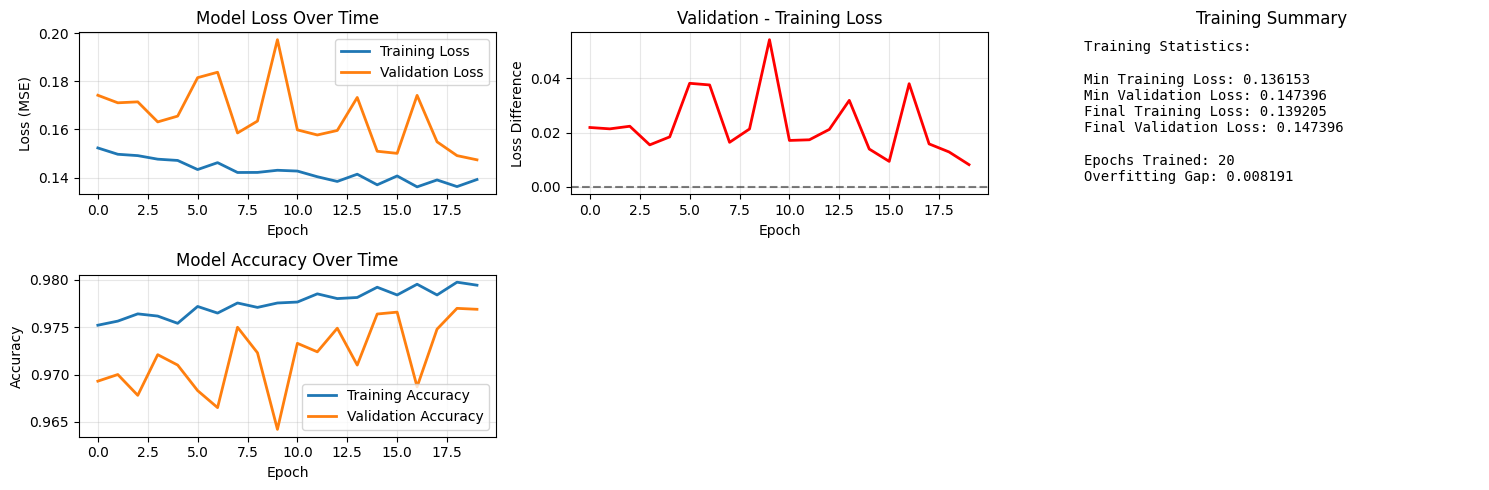

In [228]:
plot_training_history(history)

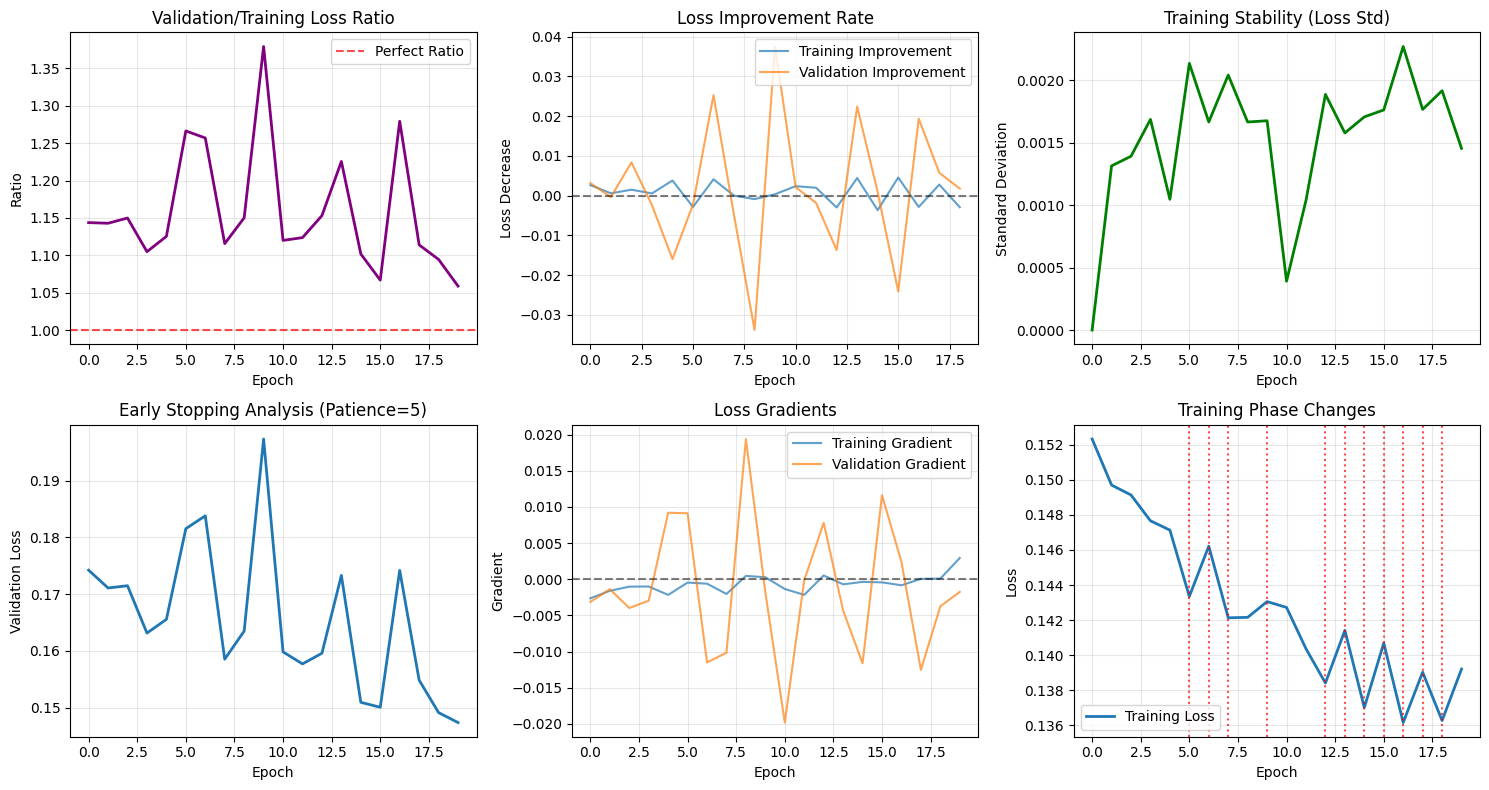

In [229]:
plot_loss_landscape_analysis(history)

Early Stopping Analysis shows (if applicable) a red vertical line where the validation loss stopped improving in the last 5 epochs.

Training Phase Changes marks with vertical red lines (if applicable) where the training loss switches from increasing to decreasing.

Train errors shape: (1000,)
Test errors shape: (1000,)


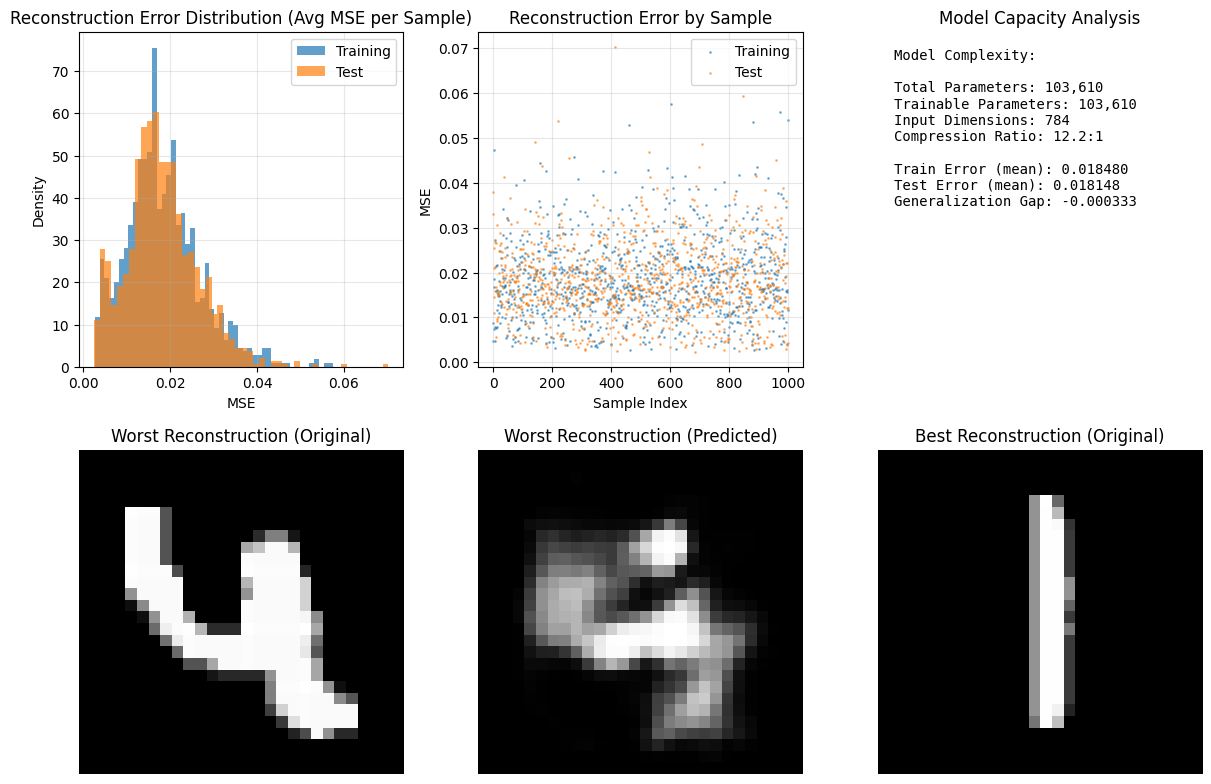

In [230]:
analyze_model_capacity(autoencoder, x_train, x_test)

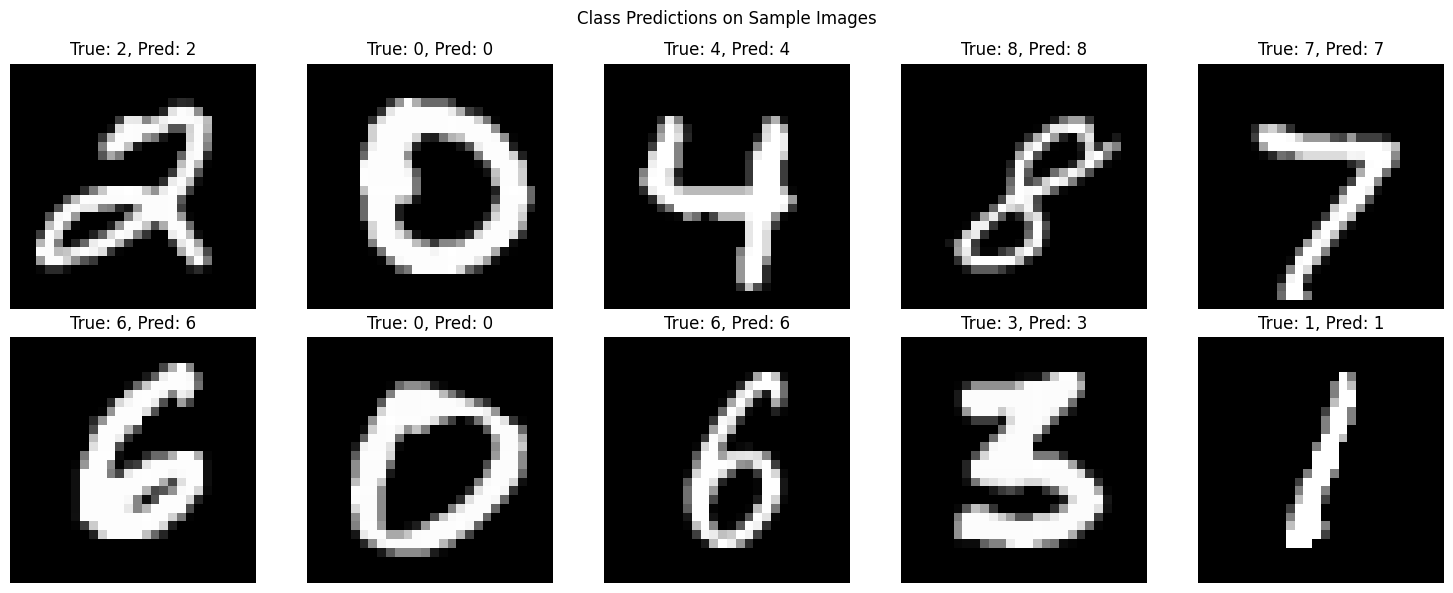

Failed Classification Example - True: 9, Predicted: 0


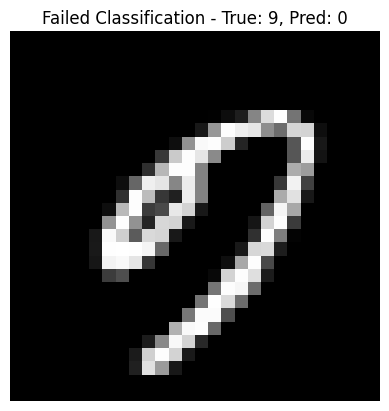

In [231]:
def visualize_class_predictions(model, x_sample, y_sample):
    """Visualize class predictions on sample images"""
    predictions = model(x_sample)
    class_probs = predictions[1]
    predicted_classes = tf.argmax(class_probs, axis=1).numpy()
    
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_sample[i].squeeze(), cmap='gray')
        plt.title(f'True: {y_sample[i]}, Pred: {predicted_classes[i]}')
        plt.axis('off')
    plt.suptitle('Class Predictions on Sample Images')
    plt.tight_layout()
    plt.show()

    # find an example of a failed classification
    for i in range(len(y_sample)):
        if predicted_classes[i] != y_sample[i]:
            print(f"Failed Classification Example - True: {y_sample[i]}, Predicted: {predicted_classes[i]}")
            plt.figure()
            plt.imshow(x_sample[i].squeeze(), cmap='gray')
            plt.title(f'Failed Classification - True: {y_sample[i]}, Pred: {predicted_classes[i]}')
            plt.axis('off')
            plt.show()
            break

visualize_class_predictions(autoencoder, x_test, test_labels)

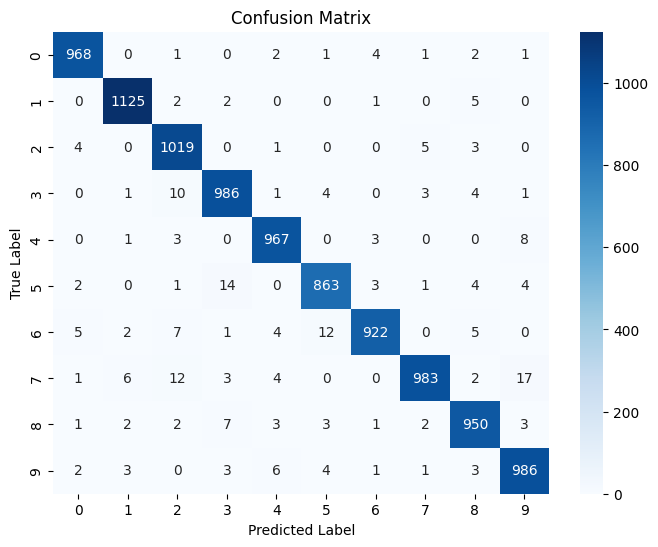

In [232]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns   

def plot_confusion_matrix(model, x_test, y_test):
    """Plot confusion matrix for model predictions"""
    predictions = model(x_test)
    class_probs = predictions[1]
    predicted_classes = tf.argmax(class_probs, axis=1).numpy()
    
    cm = confusion_matrix(y_test, predicted_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(autoencoder, x_test, test_labels)

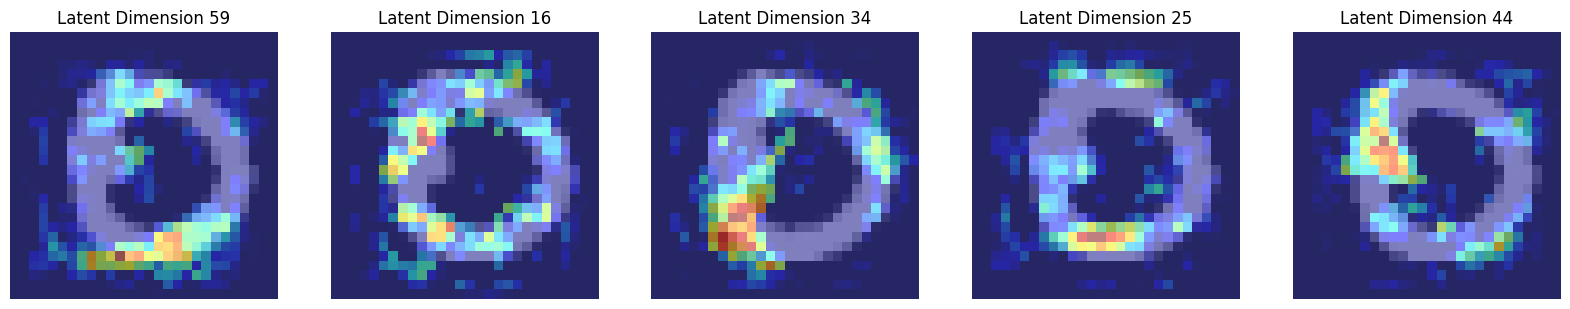

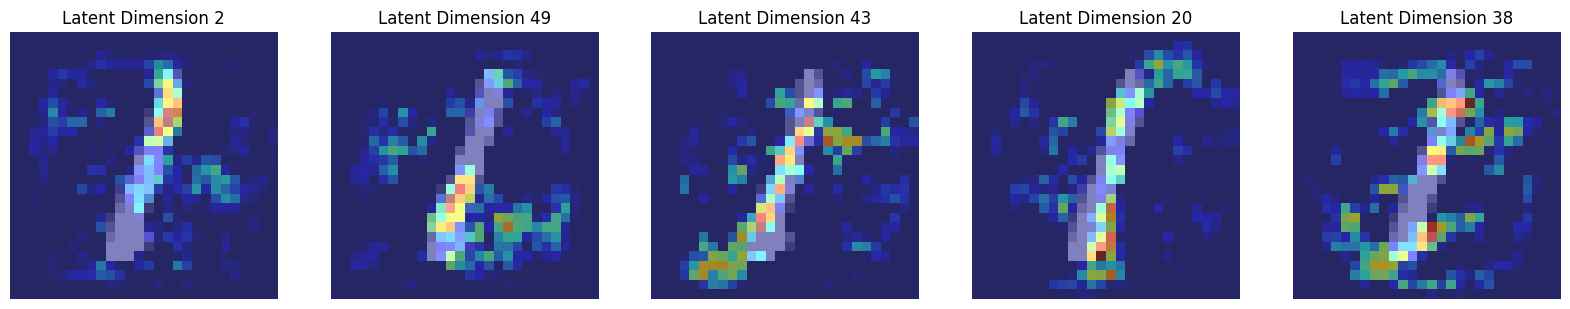

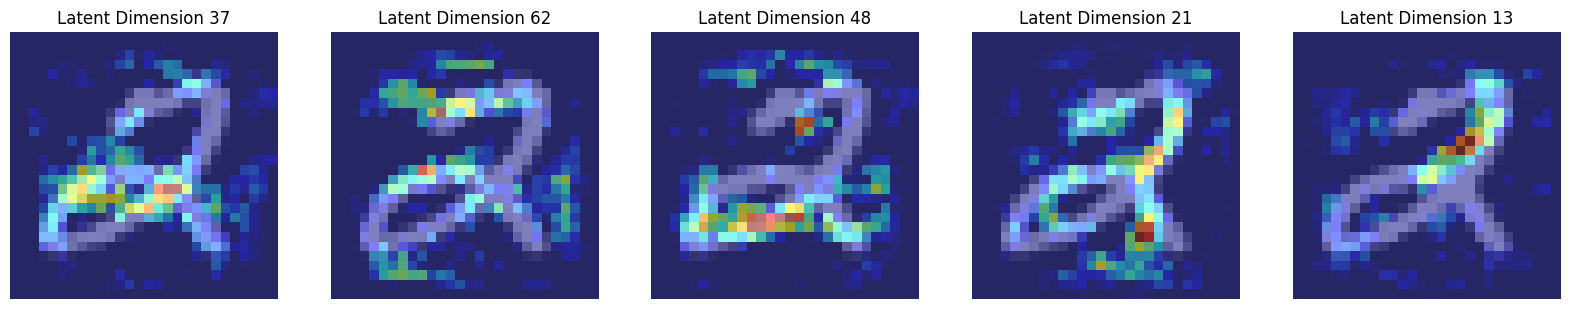

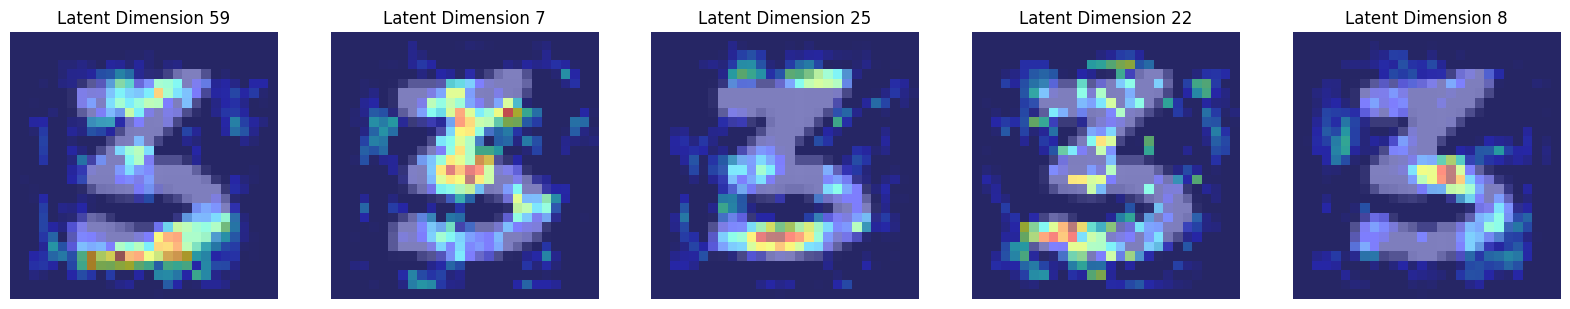

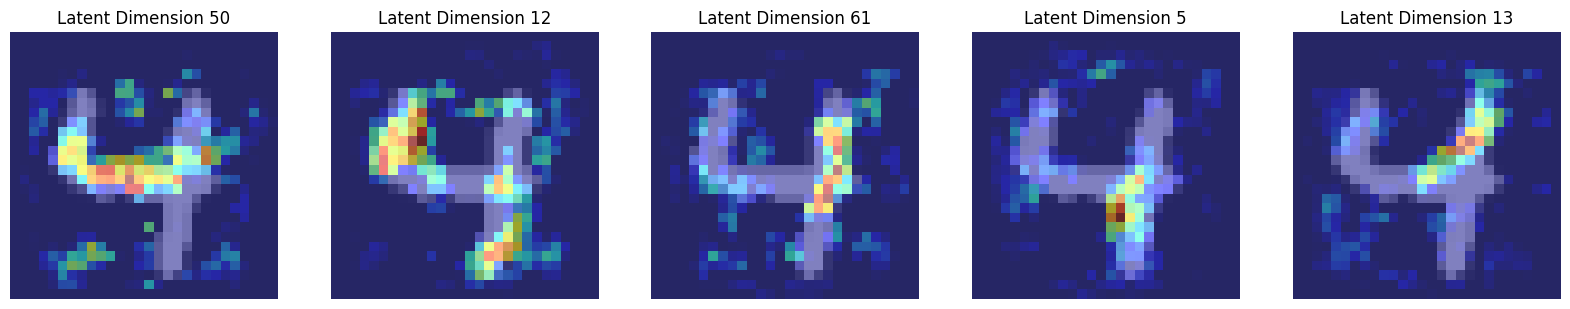

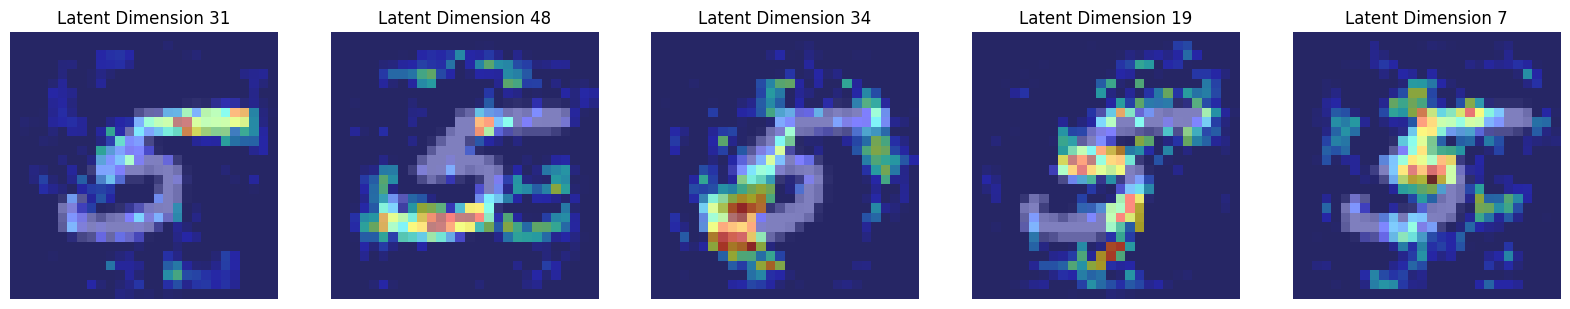

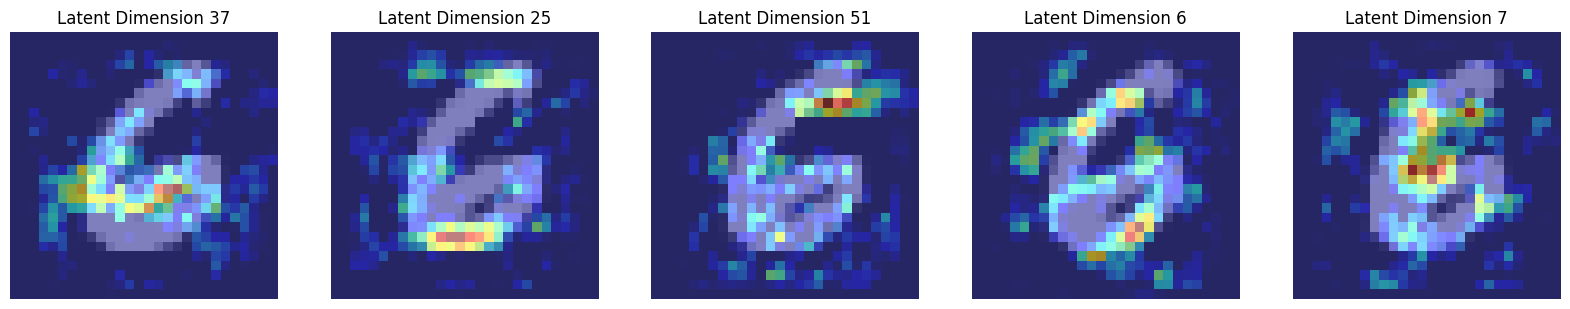

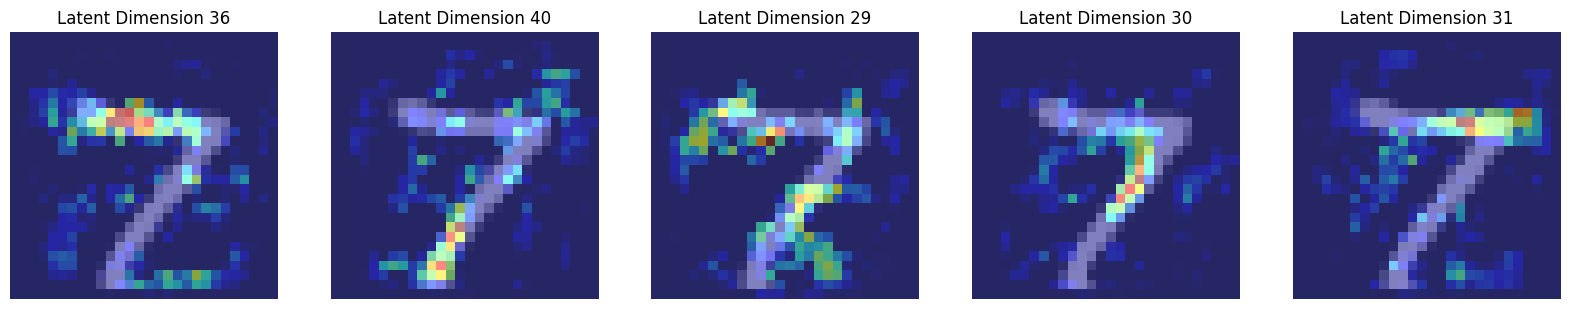

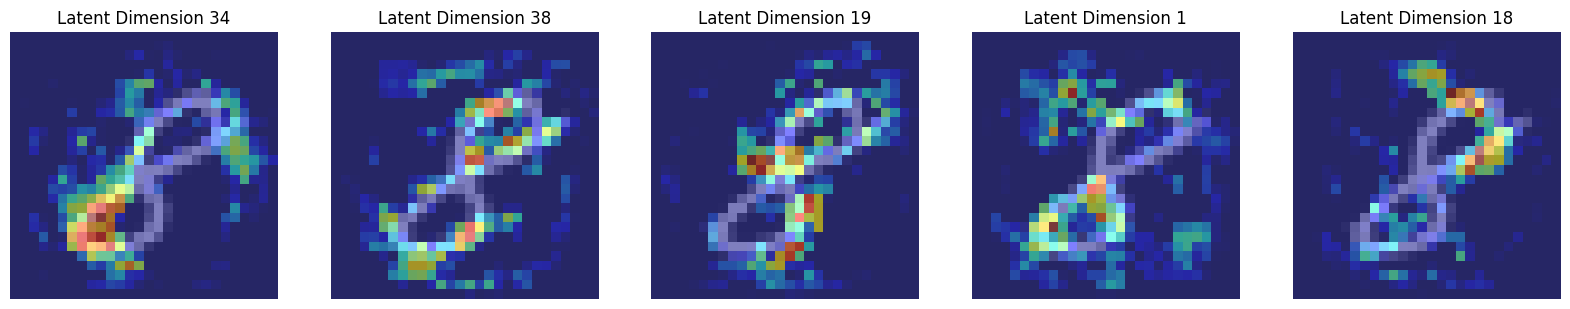

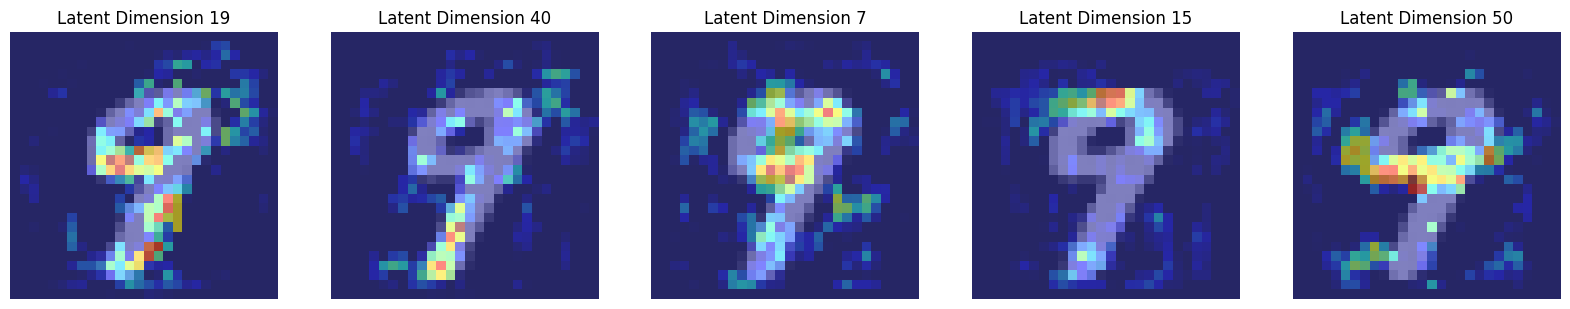

In [258]:
def visualize_top_latent_grad_cams(model, image, top_n=3):
    """
    For a given image, find the top N latent dimensions with highest activation,
    and plot Grad-CAMs for each, mapping back to spatial regions in the input.
    """
    # Ensure image has batch dimension and correct shape
    image = np.array(image)
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    # If image is not (1, 28, 28, 1), reshape it
    if image.shape != (1, 28, 28, 1):
        image = image.reshape(1, 28, 28, 1)

    # Get encoder and classifier
    encoder = model.encoder
    classifier = model.classifier

    # Forward pass to get latent vector
    latent = encoder(image).numpy()[0]  # shape: (latent_dim,)
    # Get indices of top N activations
    top_indices = np.argsort(latent)[-top_n:][::-1]

    plt.figure(figsize=(4 * top_n, 5))

    if isinstance(image, np.ndarray):
        image_np = tf.convert_to_tensor(image, dtype=tf.float32)

    for i, dim in enumerate(top_indices):
        with tf.GradientTape() as tape:
            tape.watch(image_np)
            latent_tensor = encoder(image_np)
            selected_latent = latent_tensor[:, dim]
        grads = tape.gradient(selected_latent, image_np)[0]  # shape: (28, 28, 1)
        grad_cam = np.maximum(grads, 0)
        grad_cam = grad_cam / (grad_cam.max() + 1e-8)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(image[0].squeeze(), cmap='gray', alpha=0.7)
        plt.imshow(grad_cam.squeeze(), cmap='jet', alpha=0.5)
        plt.title(f'Latent Dimension {dim}')
        plt.axis('off')

# plot example Grad-CAMs for 3 sample images of each digit
for i in range(10):
    sample_image = x_test[test_labels == i][0]
    visualize_top_latent_grad_cams(autoencoder, sample_image, top_n=5)

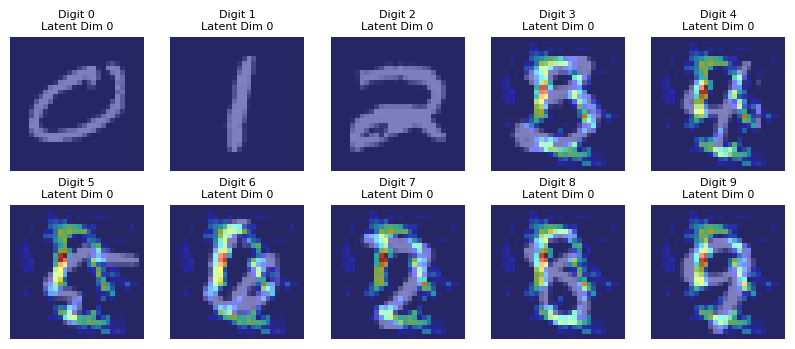

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_latent_dim_grad_cams(model, latent_dim_index, x_test, test_labels):
    """
    For a given latent vector index, produce a 2x5 grid of Grad-CAMs for random sample images of each digit 0-9.
    """
    plt.figure(figsize=(10, 4))
    digits = range(10)
    for i, digit in enumerate(digits):
        # Randomly select one sample image for this digit
        digit_indices = np.where(test_labels == digit)[0]
        if len(digit_indices) == 0:
            continue
        idx = np.random.choice(digit_indices)
        image = x_test[idx]
        # Ensure shape is (1, 28, 28, 1)
        if image.ndim == 3:
            image = np.expand_dims(image, axis=0)
        if isinstance(image, np.ndarray):
            image_tf = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image_tf = image

        # Grad-CAM for the selected latent dimension
        with tf.GradientTape() as tape:
            tape.watch(image_tf)
            latent_tensor = model.encoder(image_tf)
            selected_latent = latent_tensor[:, latent_dim_index]
        grads = tape.gradient(selected_latent, image_tf)[0]  # shape: (28, 28, 1)
        grad_cam = np.maximum(grads, 0)
        grad_cam = grad_cam / (grad_cam.max() + 1e-8)

        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(image[0].squeeze(), cmap='gray', alpha=0.7)
        ax.imshow(grad_cam, cmap='jet', alpha=0.5)
        ax.set_title(f'Digit {digit}\nLatent Dim {latent_dim_index}', fontsize=8)
        ax.axis('off')
    
visualize_latent_dim_grad_cams(autoencoder, latent_dim_index=0, x_test=x_test, test_labels=test_labels)

In [249]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

<Figure size 2000x400 with 0 Axes>

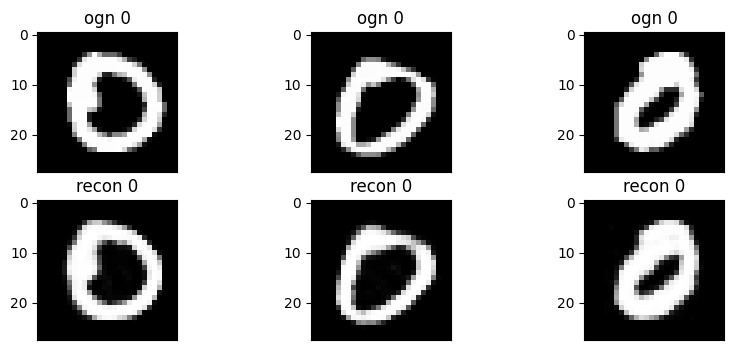

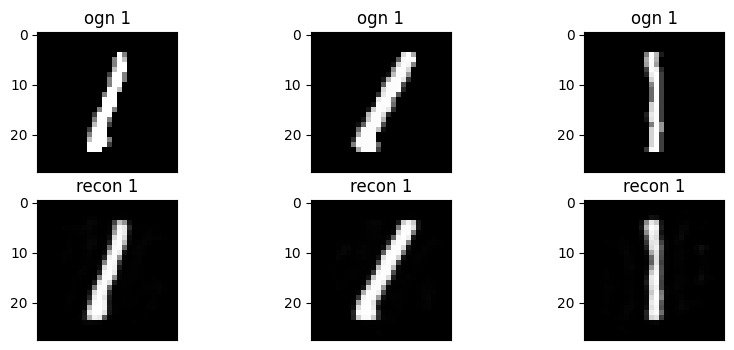

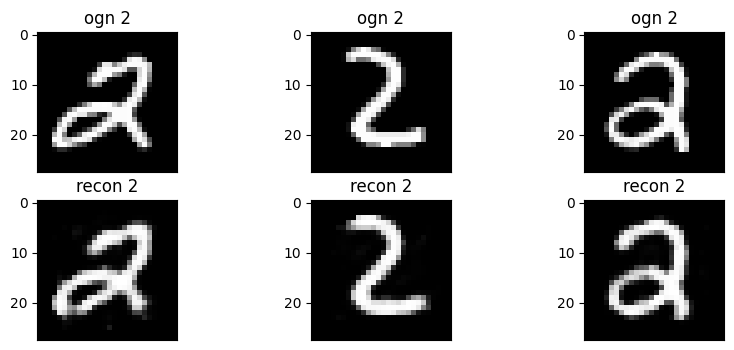

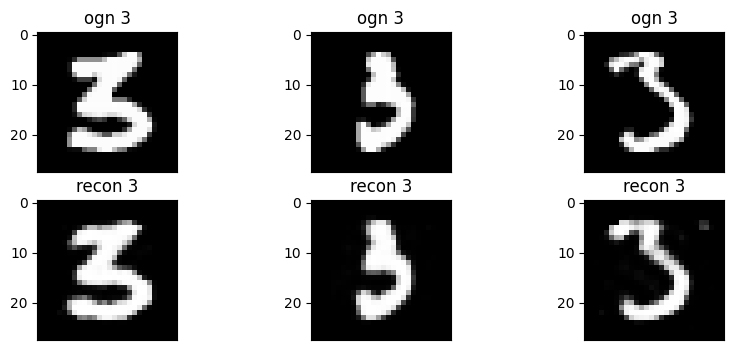

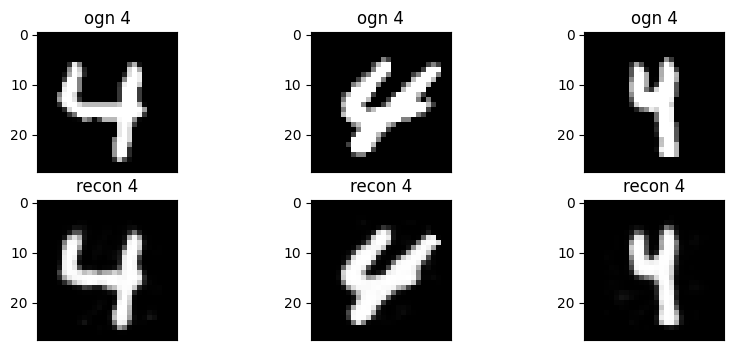

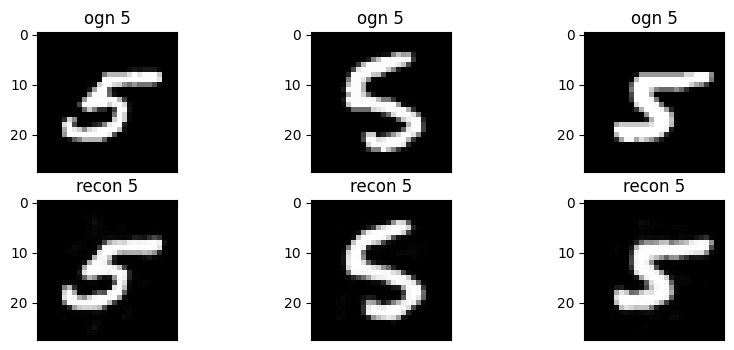

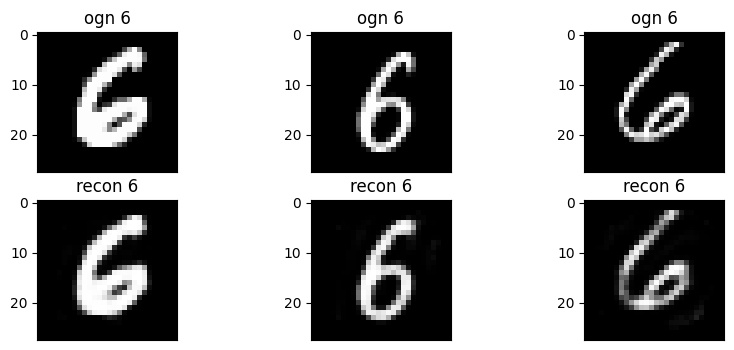

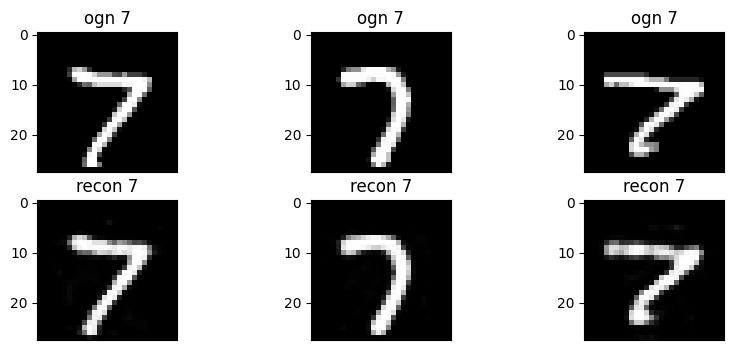

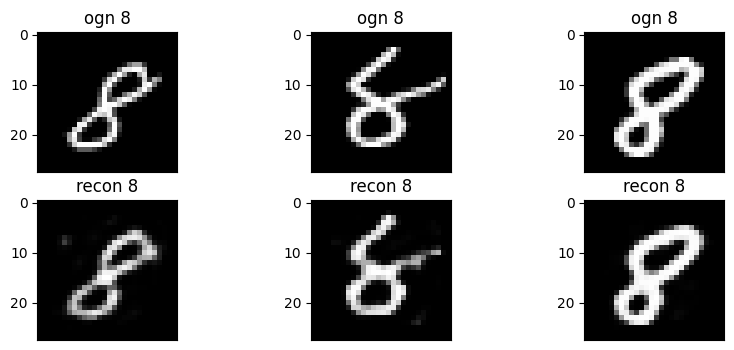

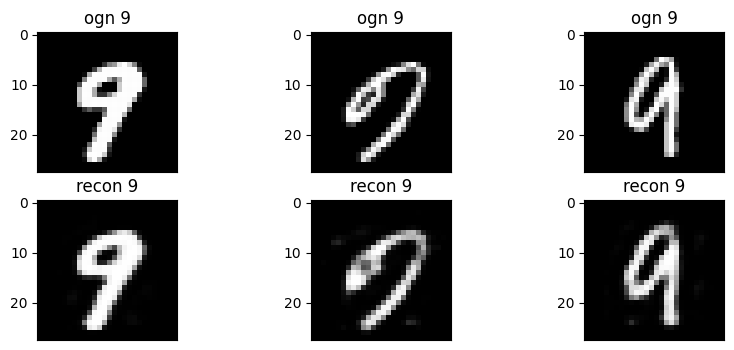

In [148]:
n = 10
plt.figure(figsize=(20, 4))

original_reconstructed_tuples = [[] for _ in range(10)] # access by index for digits 0-9

# iterate through encoded and decoded images
for i in range(encoded_imgs.shape[0]):
    label = test_labels[i]
    original_reconstructed_tuples[label].append((x_test[i], encoded_imgs[i], decoded_imgs[i], test_labels[i]))

# iterate through digits 0-9
n_examples = 3
for i in range(10):
   # iterate through associated tuples (take only first n_examples)
   plt.figure(figsize=(10, 4))
   count = 0
   for img, encoded_img, decoded_img, label in original_reconstructed_tuples[i][0:n_examples]:
       
       # plot original image in top row
       ax = plt.subplot(2, 3, count + 1)
       plt.imshow(img.squeeze(), cmap='gray')
       plt.title(f"ogn {i}")
       plt.gray()
       ax.get_xaxis().set_visible(False)

       ax = plt.subplot(2, 3, count + 1 + n_examples)
       plt.imshow(decoded_img.squeeze(), cmap='gray')
       plt.title(f"recon {i}")
       plt.gray()
       ax.get_xaxis().set_visible(False)
       
       count += 1
       if count >= n_examples:
           break

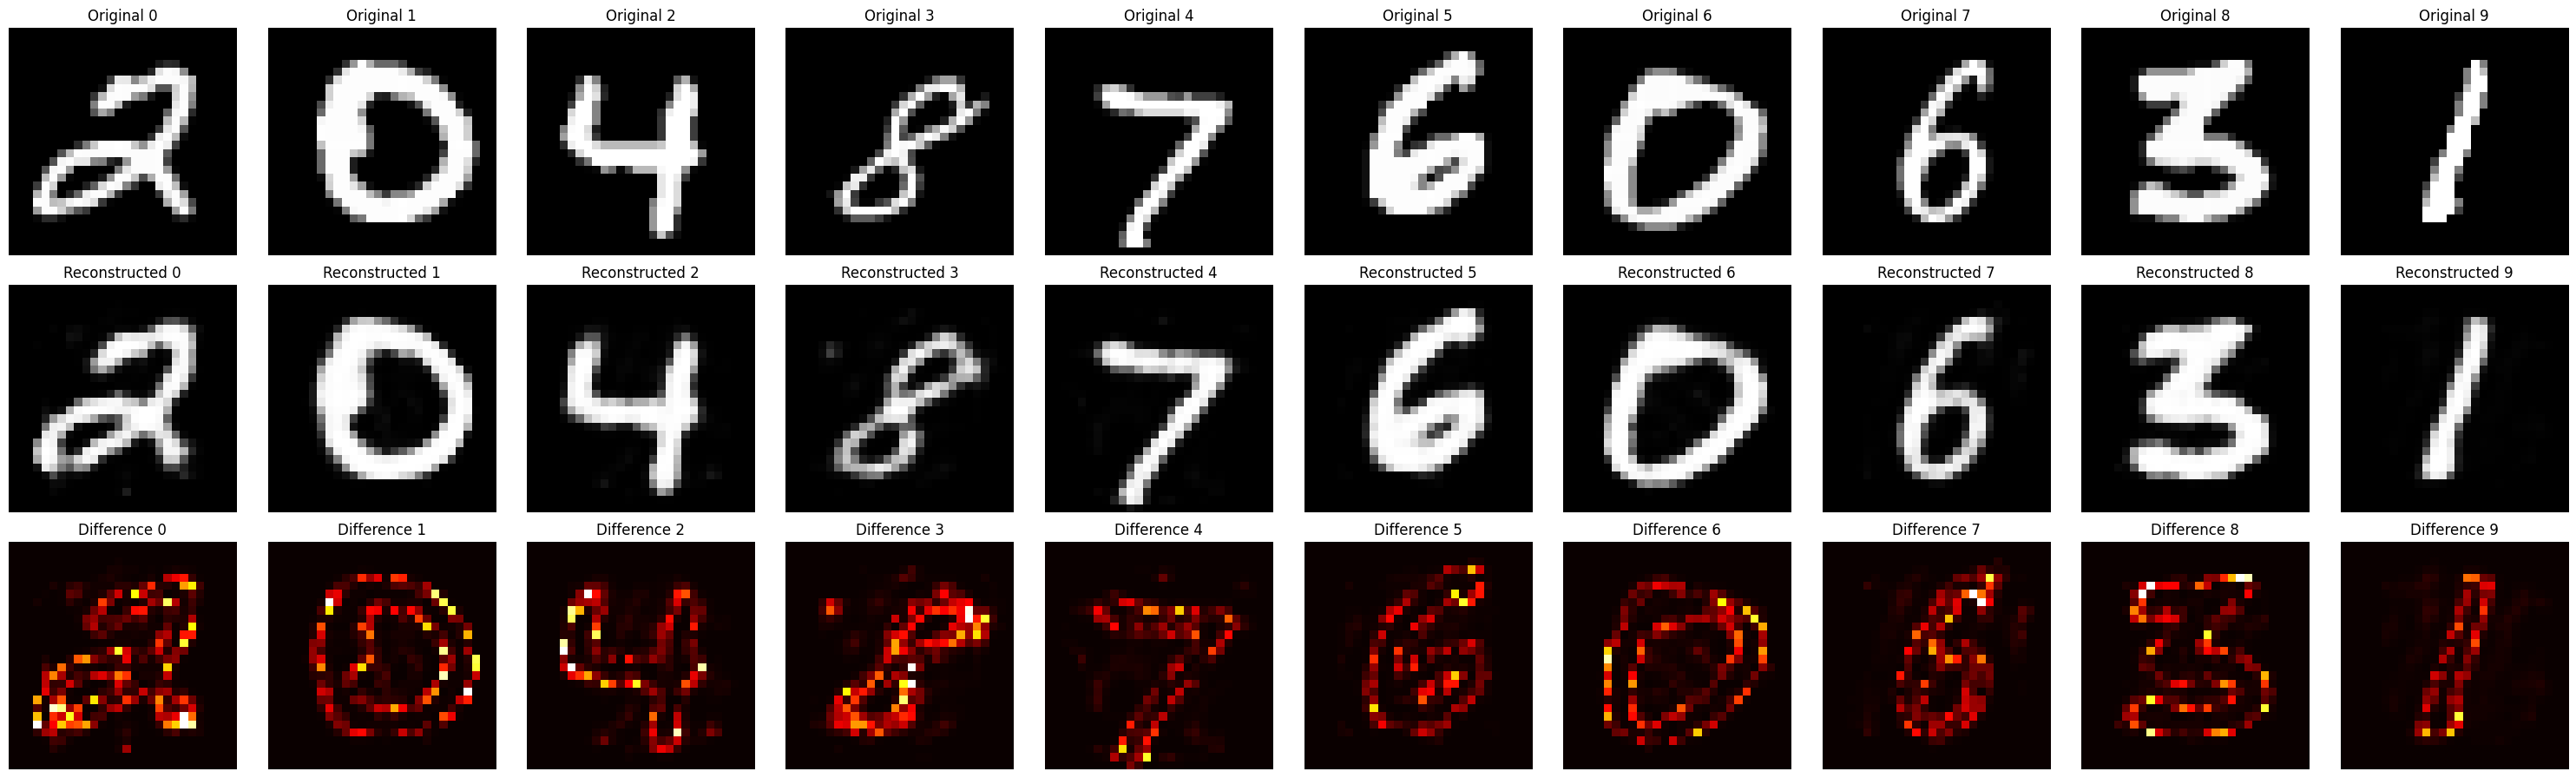

In [149]:
# Calculate pixel-wise differences
differences = np.abs(x_test[:10] - decoded_imgs[:10])

plt.figure(figsize=(30, 12))
for i in range(10):
    # Original
    plt.subplot(4, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"Original {i}")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(4, 10, i + 11)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title(f"Reconstructed {i}")
    plt.axis('off')
    
    # Difference heatmap
    plt.subplot(4, 10, i + 21)
    plt.imshow(differences[i].squeeze(), cmap='hot', vmin=0, vmax=0.5)
    plt.title(f"Difference {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Interpreting the Difference Analysis

### Understanding the Difference Heatmaps
The **difference heatmaps** (third row) show the absolute pixel-wise differences between original and reconstructed images using a "hot" colormap:
- **Dark/Black areas**: Pixels with little to no difference (good reconstruction)
- **Bright/Yellow-Red areas**: Pixels with large differences (poor reconstruction)

**Key Observation**: The brightest regions typically appear at the **edges and boundaries** of each digit. This indicates that the autoencoder struggles most with fine details and sharp transitions between foreground (digit) and background pixels. The model tends to blur or smooth these edge regions during reconstruction.

### Understanding the Difference Histograms
The **difference histograms** (bottom row) show the distribution of pixel-wise differences for each image:

**X-axis**: Difference values (ranging from 0 to ~0.5)
- 0 = Perfect reconstruction (no difference)
- Higher values = Larger reconstruction errors

**Y-axis**: Count of pixels with that difference value

**Key Observations**:
1. **Largest bin at 0**: Most pixels have zero or near-zero difference, indicating the autoencoder successfully reconstructs the majority of pixels
2. **Right-skewed distribution**: Few pixels have large errors, confirming that major reconstruction issues are localized to specific regions (mainly edges)
3. **Long tail**: Some pixels have moderate to high errors, representing the edge artifacts and fine detail losses

This analysis confirms that while the autoencoder performs well overall, it systematically struggles with preserving sharp edges and fine details - a common limitation of

Label of the original image: 4


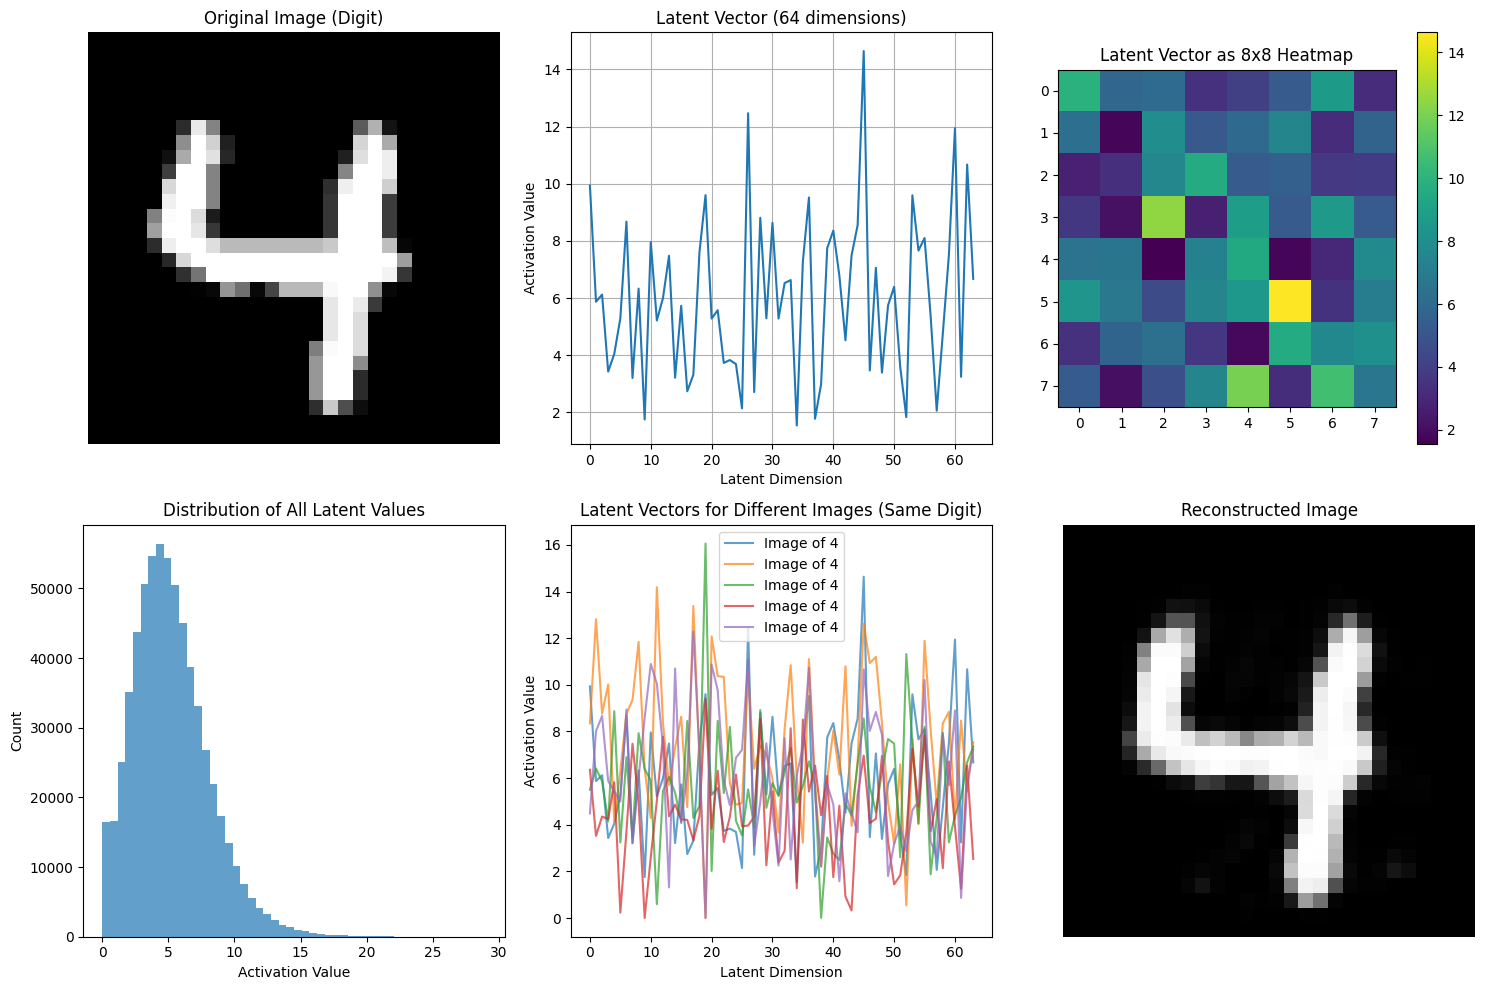

In [150]:
# Visualize what the encoder learns - the latent representations
def visualize_latent_space(x_test, labels, index):
    # Get encoded representations for a batch of images

    sample_images = x_test
    encoded_representations = autoencoder.encoder(sample_images).numpy()


    plt.figure(figsize=(15, 10))
    
    # Plot 1: Show original images
    plt.subplot(2, 3, 1)
    plt.imshow(sample_images[index].squeeze(), cmap='gray')
    plt.title('Original Image (Digit)')
    plt.axis('off')
    print(f"Label of the original image: {labels[index]}")
    
    # Plot 2: Show the 64-dimensional latent vector
    plt.subplot(2, 3, 2)
    plt.plot(encoded_representations[index])
    plt.title('Latent Vector (64 dimensions)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Activation Value')
    plt.grid(True)
    
    # Plot 3: Heatmap of latent representation
    plt.subplot(2, 3, 3)
    plt.imshow(encoded_representations[index].reshape(8, 8), cmap='viridis')
    plt.title('Latent Vector as 8x8 Heatmap')
    plt.colorbar()
    
    # Plot 4: Distribution of all latent values
    plt.subplot(2, 3, 4)
    plt.hist(encoded_representations.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of All Latent Values')
    plt.xlabel('Activation Value')
    plt.ylabel('Count')
    
    # Plot 5: Compare latent vectors for different images of the same digit
    plt.subplot(2, 3, 5)
    count=0
    for idx in range(len(labels)):
        if int(labels[idx]) != int(labels[index]): # skip images of different digits
            continue
        plt.plot(encoded_representations[idx], label=f'Image of {labels[idx]}', alpha=0.7)
        count += 1
        if count >= 5:  # Limit to 5 different images
            break
    plt.title('Latent Vectors for Different Images (Same Digit)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Activation Value')
    plt.legend()
    
    # Plot 6: Reconstruction
    reconstructed = autoencoder.decoder(encoded_representations[:index+1]).numpy()
    plt.subplot(2, 3, 6)
    plt.imshow(reconstructed[index].squeeze(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_latent_space(x_test, test_labels, index=2)

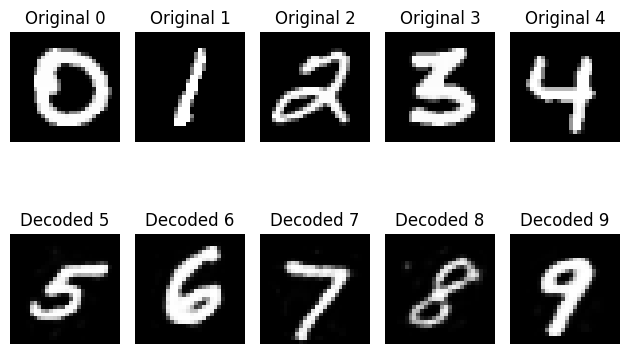

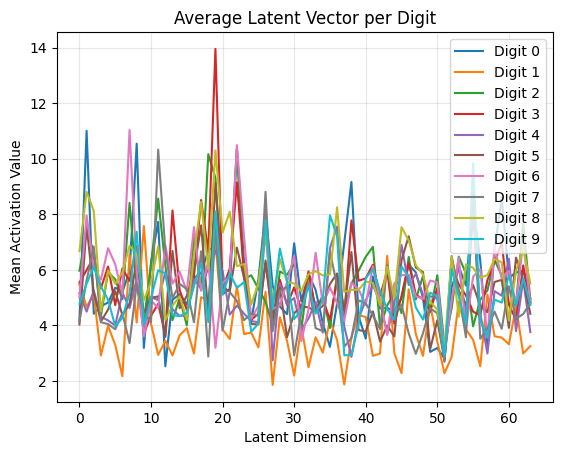

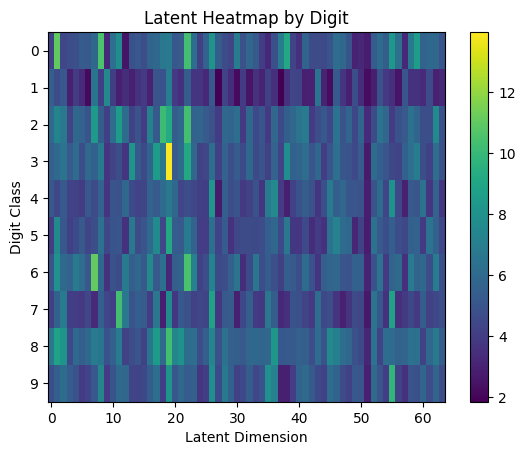

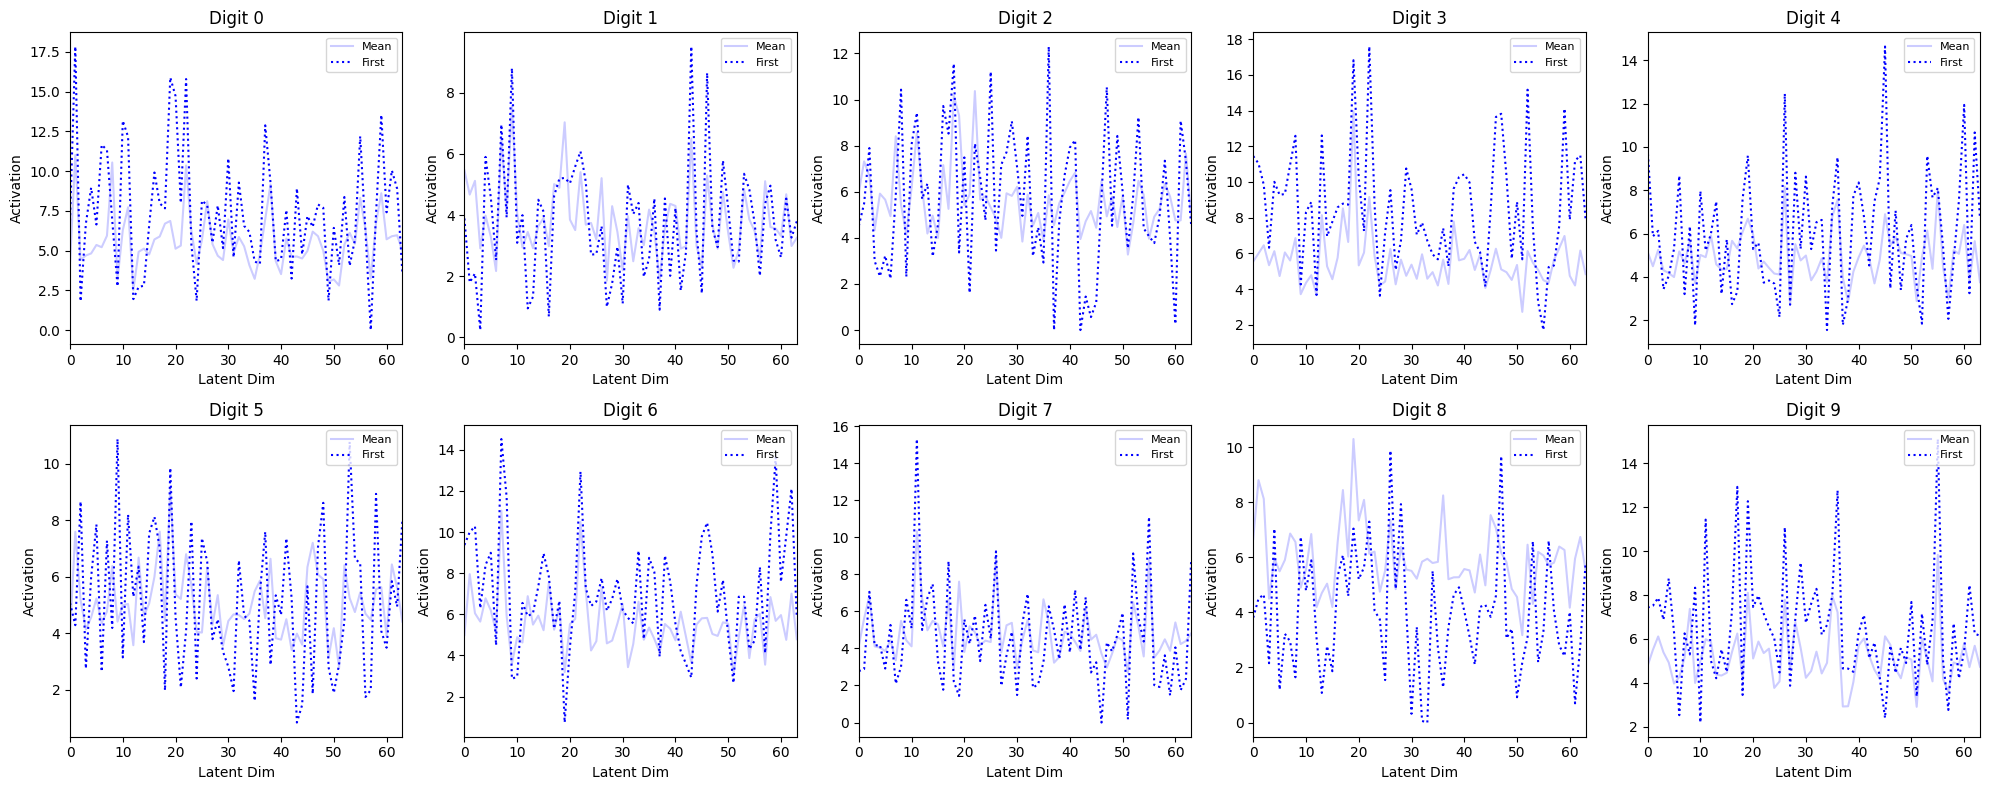

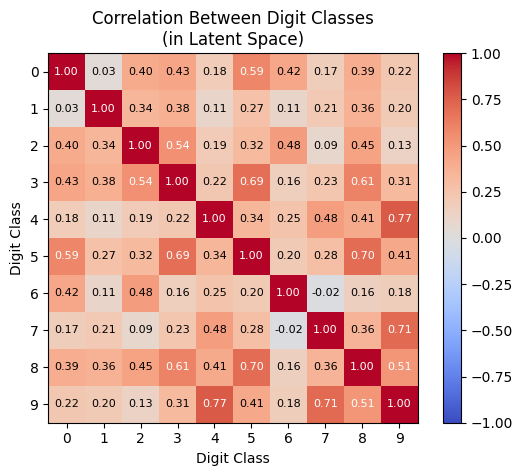

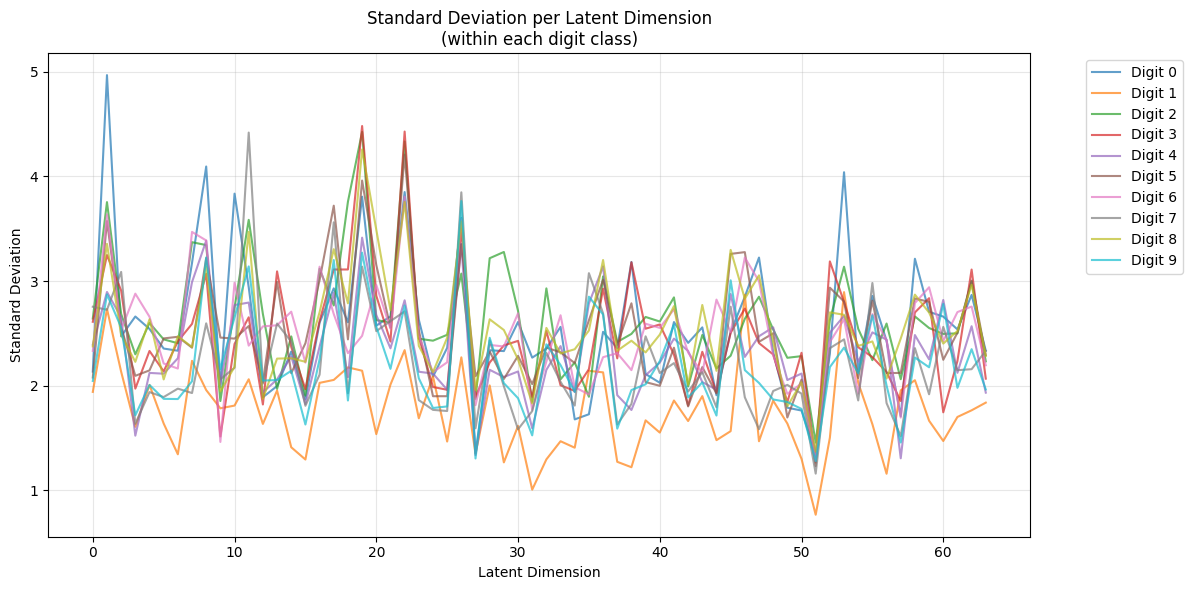

Most Correlated Digits 9 and 4: 0.768
Minimally Correlated Digits 0 and 0: -2.000


In [151]:
# Modified visualization to group latent vectors by digit class
def visualize_latent_space_by_digit():

    plt.figure()
    digits = range(10)
    for i, digit in enumerate(digits):
        # Find the first index of this digit in test_labels
        idx = np.where(test_labels == digit)[0][0]
        
        # Original image
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx].squeeze(), cmap='gray')
        plt.title(f"Original {digit}")
        plt.axis('off')
        
        # Decoded image
        plt.subplot(2, 5, i % 5 + 6)
        plt.imshow(decoded_imgs[idx].squeeze(), cmap='gray')
        plt.title(f"Decoded {digit}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

    # Plot average latent vector for each digit
    avg_latents = []

    for digit in digits:
        digit_indices = np.where(test_labels == digit)[0]
        digit_latents = encoded_imgs[digit_indices]
        mean_latent = np.mean(digit_latents, axis=0)
        avg_latents.append(mean_latent)

    plt.figure()
    for i, mean_latent in enumerate(avg_latents):
        plt.plot(mean_latent, label=f'Digit {i}')
    plt.title('Average Latent Vector per Digit')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Activation Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    # Heatmap of mean latent vectors
    mean_latents = []
    for digit in range(10):
        digit_indices = np.where(test_labels == digit)[0]
        if len(digit_indices) > 0:
            digit_latents = encoded_imgs[digit_indices]
            mean_latents.append(np.mean(digit_latents, axis=0))
        else:
            mean_latents.append(np.zeros(64))
    
    mean_latents = np.array(mean_latents)
    plt.imshow(mean_latents, cmap='viridis', aspect='auto')
    plt.title('Latent Heatmap by Digit')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Digit Class')
    plt.yticks(range(10))
    plt.colorbar()
    
    # Plot a 2x5 grid: each subplot shows mean latent (transparent) and first latent (solid) for one digit
    plt.figure(figsize=(20, 8))
    digits = range(10)
    for i, digit in enumerate(digits):
        ax = plt.subplot(2, 5, i + 1)
        # Mean latent vector (transparent)
        ax.plot(avg_latents[digit], color='blue', alpha=0.2, label='Mean')
        # First latent vector (solid)
        digit_indices = np.where(test_labels == digit)[0]
        first_latent = encoded_imgs[digit_indices[0]]
        ax.plot(first_latent, color='blue', alpha=1.0, label='First', linestyle=':')
        ax.set_title(f'Digit {digit}')
        ax.set_xlabel('Latent Dim')
        ax.set_ylabel('Activation')
        ax.set_xlim([0, len(avg_latents[digit])-1])
        ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Correlation matrix between digit classes
    correlation_matrix = np.corrcoef(mean_latents)
    im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Digit Classes\n(in Latent Space)')
    plt.xlabel('Digit Class')
    plt.ylabel('Digit Class')
    plt.xticks(range(10))
    plt.yticks(range(10))
    
    # Add correlation values as text
    for i in range(10):
        for j in range(10):
            plt.text(j, i, f'{correlation_matrix[i,j]:.2f}', 
                    ha='center', va='center', 
                    color='white' if abs(correlation_matrix[i,j]) > 0.5 else 'black',
                    fontsize=8)
    plt.colorbar(im)
    
    # Standard deviation within each class
    plt.figure(figsize=(12, 6))
    std_per_digit = []
    for digit in range(10):
        digit_indices = np.where(test_labels == digit)[0]
        if len(digit_indices) > 1:
            digit_latents = encoded_imgs[digit_indices]
            std_latent = np.std(digit_latents, axis=0)
            std_per_digit.append(np.mean(std_latent))  # Average std across dimensions
            plt.plot(std_latent, alpha=0.7, label=f'Digit {digit}')
        else:
            std_per_digit.append(0)

    plt.title('Standard Deviation per Latent Dimension\n(within each digit class)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find most correlated pairs
    correlation_matrix = np.corrcoef(mean_latents)
    np.fill_diagonal(correlation_matrix, -2)  # Ignore self-correlation
    max_corr_idx = np.unravel_index(np.argmax(correlation_matrix), correlation_matrix.shape)
    min_corr_idx = np.unravel_index(np.argmin(correlation_matrix), correlation_matrix.shape)
    print(f"Most Correlated Digits {max_corr_idx[0]} and {max_corr_idx[1]}: {correlation_matrix[max_corr_idx]:.3f}")
    print(f"Minimally Correlated Digits {min_corr_idx[0]} and {min_corr_idx[1]}: {correlation_matrix[min_corr_idx]:.3f}")

visualize_latent_space_by_digit()

# TODO: heat maps like for cats/dogs project; add a last classification layer and freeze all up to last 1-2 layers

## Interpreting the Latent Space Correlation Matrix

The correlation matrix between digit classes in latent space reveals fascinating insights about how the autoencoder perceives visual similarities:

### High Correlation (Similar Latent Representations)
- **Digits 4 and 9** show high correlation, which makes intuitive sense given their structural similarities:
  - Both contain a **straight vertical line** as a dominant feature
  - Both have an **enclosed region** (loop or angular closure) in the upper portion
  - The autoencoder appears to capture this shared "vertical line + upper enclosure" pattern

### Low Correlation (Distinct Latent Representations)
- **Digits 0 and 1** show very low correlation, reflecting their fundamental structural differences:
  - **Digit 0**: Primarily a closed loop/oval shape with no straight lines
  - **Digit 1**: Primarily a straight vertical line with minimal curvature
  - These represent opposite ends of the "curvature vs. linearity" spectrum

### Key Insights
1. **Shape-based encoding**: The autoencoder learns to encode digits based on fundamental geometric properties rather than just pixel patterns
2. **Structural similarity detection**: High correlations often correspond to digits that share basic structural elements (lines, curves, enclosures)
3. **Perceptual organization**: The latent space organization mirrors human intuition about digit similarities - we also perceive 4 and 9 as more similar than 0 and 1

This demonstrates that even a simple autoencoder with basic dense layers can learn meaningful geometric representations that capture the essential visual structure

## Investigating the Classification Layer